# Inspect YOLOv3 Model

In [1]:
import os
from pprint import pprint
from typing import Any, Callable, cast, Dict, List, Literal, Optional, Sequence, Tuple, Type, Union
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torchvision.datasets import VOCDetection, wrap_dataset_for_transforms_v2
from torchvision.transforms import v2
from torchvision.tv_tensors._dataset_wrapper import VOC_DETECTION_CATEGORIES, VOC_DETECTION_CATEGORY_TO_IDX
from torchvision import tv_tensors
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert, clip_boxes_to_image, nms, batched_nms
from torchmetrics.detection import MeanAveragePrecision
from torchinfo import summary
import sys
sys.path.append('../')
from models.yolov3 import Yolov3Config, Yolov3
from dataloaders.voc import add_img_border_box, Resize, Voc2Yolov3, voc_collate_fn
from evaluator import DetEvaluator
from torch.utils.tensorboard import SummaryWriter
# palette is a list of color tuples, which is used for visualization.
palette =  [(106, 0, 228), (119, 11, 32), (165, 42, 42), (0, 0, 192),
            (197, 226, 255), (0, 60, 100), (0, 0, 142), (255, 77, 255),
            (153, 69, 1), (120, 166, 157), (0, 182, 199),
            (0, 226, 252), (182, 182, 255), (0, 0, 230), (220, 20, 60),
            (163, 255, 0), (0, 82, 0), (3, 95, 161), (0, 80, 100),
            (183, 130, 88)]

## Inspect Structure & In/Out Shape

In [2]:
img_h, img_w = 416, 416
n_class = 80  # 80 for coco, 20 for voc
n_scale = 3
n_anchor_per_scale = 3
anchors = (
    ((10, 13), (16, 30), (33, 23)),
    ((30, 61), (62, 45), (59, 119)),
    ((116, 90), (156, 198), (373, 326)),
)

model_args = dict(
    img_h=img_h,
    img_w=img_w,
    n_class=n_class,
    n_scale=n_scale,
    n_anchor_per_scale=n_anchor_per_scale,
    anchors=anchors,
)

model_config = Yolov3Config(**model_args)
model = Yolov3(model_config)

batch_size = 1
summary(model, input_size=[(batch_size, 3, img_h, img_w),], device='cuda',
        col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"), verbose=2,
        depth=4, row_settings=("depth", "var_names"));
model.to('cpu')

number of parameters: 61.95M
Layer (type (var_name):depth-idx)                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds                 Trainable
Yolov3 (Yolov3)                                         [1, 3, 416, 416]          [1, 3, 52, 52, 85]        --                        --                        --                        True
├─Darknet53Backbone (backbone): 1-1                     [1, 3, 416, 416]          [1, 256, 52, 52]          --                        --                        --                        True
│    └─conv0.conv.weight                                                                                    ├─864                     [32, 3, 3, 3]
│    └─conv0.bn.weight                                                                                      ├─32                      [32]
│    └─conv0.bn.bias                                                                                      

Yolov3(
  (backbone): Darknet53Backbone(
    (conv0): Darknet53Conv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    )
    (conv1): Darknet53Conv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    )
    (stage1_block1): Darknet53Block(
      (conv1x1): Darknet53Conv2d(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      )
      (conv3x3): Darknet53Conv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      )
    )
    (conv2): Darknet53Conv2d(

In [14]:
writer = SummaryWriter()
imgs = torch.randn(batch_size, 3, img_h, img_w)
model.to('cpu')
writer.add_graph(model, [imgs,])
writer.close()

In [9]:
model.eval()
imgs = torch.randn(batch_size, 3, img_h, img_w)
logits = model.generate(imgs)
print("Output when eval():")
for logit in logits:
    if isinstance(logit, list):
        for l in logit:
            print(l.shape)
    elif isinstance(logit, torch.Tensor):
        print(logit.shape)
    else:  # None
        pass

Output when eval():
torch.Size([0, 8])
torch.Size([1, 3, 52, 52, 85])
torch.Size([1, 3, 26, 26, 85])
torch.Size([1, 3, 13, 13, 85])


In [11]:
model.train()
imgs = torch.randn(batch_size, 3, img_h, img_w)
logits = model(imgs)
print("Output when train():")
for logit in logits:
    if isinstance(logit, torch.Tensor):
        print(logit.shape)
    else:  # None
        pass

Output when train():
torch.Size([1, 3, 52, 52, 85])
torch.Size([1, 3, 26, 26, 85])
torch.Size([1, 3, 13, 13, 85])


In [12]:
model.train()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {total_params}")

Number of trainable parameters: 61949149


## Inspect state_dict

In [13]:
import tempfile

# Save state_dict as a temporary file
with tempfile.NamedTemporaryFile(suffix='.pth') as temp_file:
    torch.save(model.state_dict(), temp_file.name)
    state_dict = torch.load(temp_file.name)

# Print the keys of the state_dict
for key in state_dict.keys():
    print(key)


anchors_scale3
anchors_scale4
anchors_scale5
backbone.conv0.conv.weight
backbone.conv0.bn.weight
backbone.conv0.bn.bias
backbone.conv0.bn.running_mean
backbone.conv0.bn.running_var
backbone.conv0.bn.num_batches_tracked
backbone.conv1.conv.weight
backbone.conv1.bn.weight
backbone.conv1.bn.bias
backbone.conv1.bn.running_mean
backbone.conv1.bn.running_var
backbone.conv1.bn.num_batches_tracked
backbone.stage1_block1.conv1x1.conv.weight
backbone.stage1_block1.conv1x1.bn.weight
backbone.stage1_block1.conv1x1.bn.bias
backbone.stage1_block1.conv1x1.bn.running_mean
backbone.stage1_block1.conv1x1.bn.running_var
backbone.stage1_block1.conv1x1.bn.num_batches_tracked
backbone.stage1_block1.conv3x3.conv.weight
backbone.stage1_block1.conv3x3.bn.weight
backbone.stage1_block1.conv3x3.bn.bias
backbone.stage1_block1.conv3x3.bn.running_mean
backbone.stage1_block1.conv3x3.bn.running_var
backbone.stage1_block1.conv3x3.bn.num_batches_tracked
backbone.conv2.conv.weight
backbone.conv2.bn.weight
backbone.conv2.

## Inspect gradients

In [15]:
class DebugDependencyYolov3(Yolov3):
    """Yolov2 with dummy loss function for debugging dependencies."""
    def __init__(self, loss_img_idx, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_img_idx = loss_img_idx

    def _compute_loss(self, logit_scale3: Tensor, logit_scale4: Tensor, logit_scale5: Tensor, target: Tensor) -> Tuple[Tensor, ...]:
        """
        Compute the dummy loss as sum of all outputs of img i.
        Args:
            logit_scale3 (Tensor): size(N, n_anchor_per_scale, img_h / 8, img_w / 8, 5 + n_class)
            logit_scale4 (Tensor): size(N, n_anchor_per_scale, img_h / 16, img_w / 16, 5 + n_class)
            logit_scale5 (Tensor): size(N, n_anchor_per_scale, img_h / 32, img_w / 32, 5 + n_class)
            target (Tensor): size(n_batch_obj, 6)
        Returns:
            loss (Tensor): size(,)
            loss_obj (Tensor): size(,)
            loss_class (Tensor): size(,)
            loss_box (Tensor): size(,)
        """
        return (torch.sum(logit_scale3[self.loss_img_idx])
                + torch.sum(logit_scale4[self.loss_img_idx])
                + torch.sum(logit_scale5[self.loss_img_idx])), None, None, None

To verify no inadvertently mix information across the batch dimension, run the backward pass all the way to the input, and ensure that you get a non-zero gradient only on the i-th input.

In [16]:
batch_size = 5
n_batch_obj = 58
X = torch.randn(batch_size, 3, img_h, img_w, requires_grad=True)
Y =  targets = torch.randn(n_batch_obj, 6)

In [19]:
print("Setup:")
torch.manual_seed(1337);  # since kaiming_normal_ weight init is random
loss_img_idx = 2
debug_dependency_model = DebugDependencyYolov3(loss_img_idx, model_config)
debug_dependency_model.eval()  # since batchnorm will mixed variables between images in a batch

optimizer_type = 'adam'
learning_rate = 3e-4
beta1 = 0.9
beta2 = 0.999
weight_decay = 5e-4
device_type = 'cpu'
use_fused = False
optimizer = debug_dependency_model.configure_optimizers(optimizer_type, learning_rate, (beta1, beta2), weight_decay, device_type, use_fused)

print("\n\nForward pass:")
logit_scale3, logit_scale4, logit_scale5, loss, _, _, _ = debug_dependency_model(X, Y)
print(f"{logit_scale3.shape=}, {logit_scale4.shape=}, {logit_scale5.shape=}")
print(f"{loss=}")

print("\n\nBackward pass & Gradients of X::")
optimizer.zero_grad(set_to_none=True)
X.grad = None  # zero out X gradients
loss.backward()

print(f"{X.grad.shape=}")
for idx_img in range(batch_size):
    print(f"Zero gradient of {idx_img}'th img: {torch.all(X.grad[idx_img]==0)}")

print("\n\nOptimizer step:")
optimizer.step()
print(f"Loss after optimized: {debug_dependency_model(X, Y)[3]}")

Setup:
number of parameters: 61.95M
num decayed parameter tensors: 75, with 61,895,776 parameters
num non-decayed parameter tensors: 147, with 53,373 parameters
using fused Adam: False


Forward pass:
logit_scale3.shape=torch.Size([5, 3, 52, 52, 85]), logit_scale4.shape=torch.Size([5, 3, 26, 26, 85]), logit_scale5.shape=torch.Size([5, 3, 13, 13, 85])
loss=tensor(-4222110., grad_fn=<AddBackward0>)


Backward pass & Gradients of X::
X.grad.shape=torch.Size([5, 3, 416, 416])
Zero gradient of 0'th img: True
Zero gradient of 1'th img: True
Zero gradient of 2'th img: False
Zero gradient of 3'th img: True
Zero gradient of 4'th img: True


Optimizer step:
Loss after optimized: -4223044.5


## Inspect output, post-processing, prediction

In [2]:
from_ckpt = '../out/yolov3_voc/20240416-151045/ckpt_last.pt'
checkpoint = torch.load(from_ckpt, map_location='cuda')
state_dict = checkpoint['model']

config = checkpoint['config']
img_h, img_w = config['img_h'], config['img_w']  # try: (320, 352, 384, 416, 448, 480, 512, 544, 576, 608)
n_class, n_scale, n_anchor_per_scale = config['n_class'], config['n_scale'], config['n_anchor_per_scale']
anchors = config['anchors']

model_args = dict(
    img_h=img_h, img_w=img_w, n_class=n_class, n_scale=n_scale, n_anchor_per_scale=n_anchor_per_scale, anchors=anchors
)
model_config = Yolov3Config(**model_args)
model = Yolov3(model_config)

model.load_state_dict(state_dict)
model.to('cuda');

pprint(config)

number of parameters: 61.63M
{'always_save_checkpoint': True,
 'anchors': (((10, 13), (16, 30), (33, 23)),
             ((30, 61), (62, 45), (59, 119)),
             ((116, 90), (156, 198), (373, 326))),
 'aug_type': 'default',
 'autocontrast_p': 0.1,
 'balance': (4.0, 1.0, 0.4),
 'batch_size': 64,
 'beta1': 0.74832,
 'beta2': 0.999,
 'blur_p': 0.1,
 'blur_sigma_max': 2.0,
 'blur_sigma_min': 0.1,
 'blur_size_max': 7,
 'blur_size_min': 3,
 'brightness': 0.6,
 'channelshuffle_p': 0.0,
 'color_p': 1.0,
 'compile': False,
 'contrast': 0.6,
 'crop_scale': 0.75,
 'dataset_name': 'voc',
 'decay_lr': 'cosine',
 'degrees': 5.0,
 'device': 'cuda',
 'dtype': 'bfloat16',
 'eval_interval': 777,
 'eval_iters': 78,
 'eval_only': False,
 'fill': (123.0, 117.0, 104.0),
 'flip_p': 0.5,
 'from_ckpt': 'saved/darknet53-448_imagenet2012/20240404-112658/ckpt_last.pt',
 'grad_clip': 0.0,
 'gradient_accumulation_steps': 1,
 'grayscale_p': 0.1,
 'hue': 0.3,
 'img_h': 416,
 'img_w': 416,
 'imgs_mean': (0.0, 0.0,

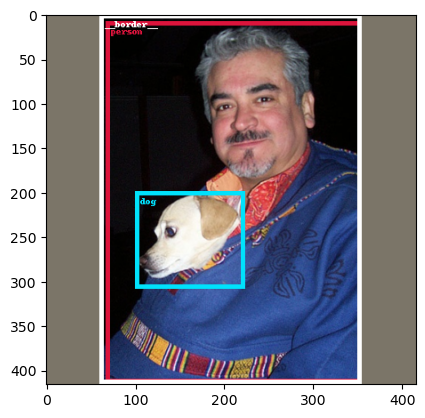

In [3]:
letterbox, fill, imgs_mean, imgs_std = config['letterbox'], config['fill'], config['imgs_mean'], config['imgs_std']

transforms = v2.Compose([
    add_img_border_box,
    Resize(size=(img_h, img_w), letterbox=letterbox, fill=fill, antialias=True),
    v2.ToImage(),
    v2.ClampBoundingBoxes(),
    v2.SanitizeBoundingBoxes(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=imgs_mean, std=imgs_std),
    Voc2Yolov3(),
])
dataset = VOCDetection(root='../data/voc', year='2007', image_set='test', download=False, transforms=transforms)  # image_set='test' for eval, 'train' for debug
dataset_v2 = wrap_dataset_for_transforms_v2(dataset, target_keys=['boxes', 'labels'])

img, y, border = dataset_v2[0]
y = Voc2Yolov3.inv_target_transform(img, y)
labels = [VOC_DETECTION_CATEGORIES[idx+1] for idx in y['labels']]  # +1 because background 0 is removed in y_supp
img_gt = draw_bounding_boxes(v2.functional.to_dtype(img, torch.uint8, scale=True), labels=labels, boxes=y['boxes'],
                             colors=[palette[idx] for idx in y['labels']], width=5)
img_gt = draw_bounding_boxes(img_gt, labels=['__border__'],
                             boxes=(border * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)).unsqueeze(0),
                             colors=[(255, 255, 255)], width=5)
plt.imshow(img_gt.permute(1, 2, 0).numpy())
plt.show()

mAP only consider the classes that are in the ground truth of the entire dataset

grid (6, 6)
  class: person (1.00)
  scale 5 anchor 2 objectness: 0.83, score: 0.8292


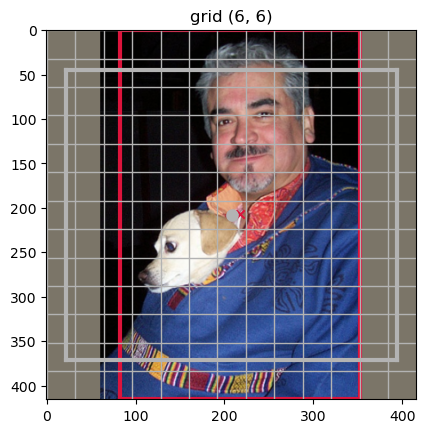

grid (8, 5)
  class: dog (0.93)
  scale 5 anchor 0 objectness: 0.07, score: 0.0606


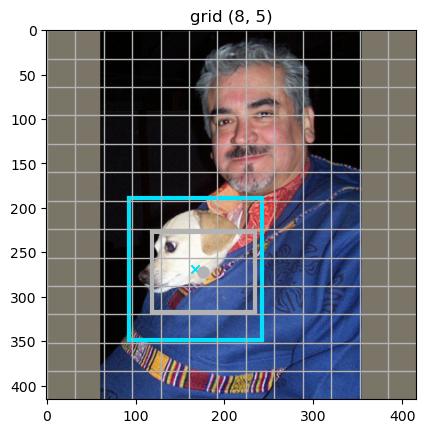

In [6]:
score_thresh = 0.05
iou_thresh = 0.5

with torch.inference_mode():
    imgs, borders = torch.unsqueeze(img, dim=0), torch.unsqueeze(border, dim=0)
    imgs, borders = imgs.to('cuda'), borders.to('cuda')
    model.eval()
    logit_scale3, logit_scale4, logit_scale5, _, _, _, _ = model(imgs)
    dtype, device = logit_scale3.dtype, logit_scale3.device

    # Reorg logits and restored to prediction
    raw_pred = []  # inference output without NMS or post-processing
    logits_scale = [logit_scale3, logit_scale4, logit_scale5]
    anchors_scale = [model.anchors_scale3, model.anchors_scale4, model.anchors_scale5]
    strides_scale = [model.stride_scale3, model.stride_scale4, model.stride_scale5]
    for idx_scale, (logit, anchor, stride) in enumerate(zip(logits_scale, anchors_scale, strides_scale)):
        batch_size, _, n_cell_h, n_cell_w, _ = logit.shape
        grid, anchor_grid = model._make_grid(n_cell_h, n_cell_w, anchor, stride)
        xy, wh, conf, prob_class = torch.split(torch.sigmoid(logit), [2, 2, 1, n_class], dim=-1)
        xy = (xy * 2 - 0.5 + grid) * stride
        wh = (wh * 2) ** 2 * anchor_grid
        pred = torch.cat([
            xy, wh, conf, prob_class, grid, torch.full_like(conf, idx_scale),
            torch.arange(n_anchor_per_scale, dtype=dtype, device=device).repeat_interleave(n_cell_h * n_cell_w).view_as(conf),
        ], dim=-1)
        raw_pred.append(pred.view(batch_size, n_anchor_per_scale * n_cell_h * n_cell_w, 5 + n_class + 4))
    raw_pred = torch.cat(raw_pred, dim=1)

    # Post-process
    for img, pred_per_img, border in zip(imgs, raw_pred, borders):  # pred_per_img: size(n_raw_pred, 5 + n_class + 4); border: size(4,), x1,y1,x2,y2 in pixels
        # Score thresholding & box clipping
        score = pred_per_img[:, 4:5] * pred_per_img[:, 5:5+n_class]  # size(n_raw_pred, n_class), conf * prob_class
        thresh_idx_pred, thresh_idx_class = torch.where(score > score_thresh)  # size(n_thresh_pred,)
        pred_per_img = torch.cat((
            clip_boxes_to_image(box_convert(pred_per_img[thresh_idx_pred, :4], in_fmt='cxcywh', out_fmt='xyxy'),
                                size=(img_h, img_w)),  # size(n_thresh_pred, 4), x1,y1,x2,y2
            pred_per_img[thresh_idx_pred, 4:5],  # size(n_thresh_pred, 1), conf
            pred_per_img[thresh_idx_pred, 5 + thresh_idx_class].unsqueeze(-1),  # size(n_thresh_pred, 1), prob_class
            thresh_idx_class.unsqueeze(-1),  # size(n_thresh_pred, 1), idx_class
            score[thresh_idx_pred, thresh_idx_class].unsqueeze(-1),  # size(n_thresh_pred, 1), score
            pred_per_img[thresh_idx_pred, -4:],  # size(n_thresh_pred, 4), grid_x,grid_y,idx_scale,idx_anchor
        ), dim=-1).to(torch.float32)  # size(n_thresh_pred, 12), x1,y1,x2,y2,conf,prob_class,idx_class,score,grid_x,grid_y,idx_scale,idx_anchor
        # Clip boxes to non-pad image border
        pred_per_img[:, 0].clamp_(min=border[0] * img_w)  # x1
        pred_per_img[:, 1].clamp_(min=border[1] * img_h)  # y1
        pred_per_img[:, 2].clamp_(max=border[2] * img_w)  # x2
        pred_per_img[:, 3].clamp_(max=border[3] * img_h)  # y2
        # NMS
        nms_idx = batched_nms(  # don't work for BFloat16
            boxes=pred_per_img[:, :4],  # size(n_thresh_pred, 4)
            scores=pred_per_img[:, 7],  # size(n_thresh_pred,)
            idxs=pred_per_img[:, 6].to(torch.int64), # size(n_thresh_pred,)
            iou_threshold=iou_thresh
        )  # size(n_nms_pred,)
        pred_per_img = pred_per_img[nms_idx]  # size(n_nms_pred, 12)

        n_pred = 0
        for x1, y1, x2, y2, conf, prob_class, idx_class, score, grid_x, grid_y, idx_scale, idx_anchor in pred_per_img.tolist():
            x1, y1, x2, y2, idx_class = int(x1), int(y1), int(x2), int(y2), int(idx_class),
            grid_x, grid_y, idx_scale, idx_anchor = int(grid_x), int(grid_y), int(idx_scale), int(idx_anchor)
            print(f"grid ({grid_y}, {grid_x})")
            print(f"  class: {VOC_DETECTION_CATEGORIES[idx_class+1]} ({prob_class:.2f})")
            print(f"  scale {idx_scale+3} anchor {idx_anchor} objectness: {conf:.2f}, score: {score:.4f}")
            plt.title(f"grid ({grid_y}, {grid_x})")
            plt.imshow(img.to('cpu').permute(1, 2, 0))

            plt.scatter((x1 + x2) // 2, (y1 + y2) // 2, marker='x', color=np.array(palette[idx_class], dtype=float) / 255.0)
            plt.plot([x1, x2], [y1, y1], color=np.array(palette[idx_class], dtype=float) / 255.0, linewidth=3)
            plt.plot([x1, x2], [y2, y2], color=np.array(palette[idx_class], dtype=float) / 255.0, linewidth=3)
            plt.plot([x1, x1], [y1, y2], color=np.array(palette[idx_class], dtype=float) / 255.0, linewidth=3)
            plt.plot([x2, x2], [y1, y2], color=np.array(palette[idx_class], dtype=float) / 255.0, linewidth=3)

            # Draw responsible anchor
            anchor_w, anchor_h = anchors[idx_scale][idx_anchor]
            stride = int(strides_scale[idx_scale])
            anchor_x, anchor_y = (grid_x + 0.5) * stride, (grid_y + 0.5) * stride
            anchor_x1, anchor_y1 = int(anchor_x - anchor_w // 2), int(anchor_y - anchor_h // 2)
            anchor_x2, anchor_y2 = int(anchor_x + anchor_w // 2), int(anchor_y + anchor_h // 2)
            plt.scatter(anchor_x, anchor_y, marker='o', color=[0.7, 0.7, 0.7], linewidths=3)
            plt.plot([anchor_x1, anchor_x2], [anchor_y1, anchor_y1], color=[0.7, 0.7, 0.7], linewidth=3)
            plt.plot([anchor_x1, anchor_x2], [anchor_y2, anchor_y2], color=[0.7, 0.7, 0.7], linewidth=3)
            plt.plot([anchor_x1, anchor_x1], [anchor_y1, anchor_y2], color=[0.7, 0.7, 0.7], linewidth=3)
            plt.plot([anchor_x2, anchor_x2], [anchor_y1, anchor_y2], color=[0.7, 0.7, 0.7], linewidth=3)
            # Draw grids
            for i in range(0, img_h, stride):
                plt.plot([0, img_w-1], [i, i], color=[0.7, 0.7, 0.7], linewidth=1)
            for i in range(0, img_w, stride):
                plt.plot([i, i], [0, img_h-1], color=[0.7, 0.7, 0.7], linewidth=1)

            plt.show()
            n_pred += 1
            if n_pred > 20:
                raise ValueError("Too much predictions. Stopped to prevent too much plotting.")

## Inspect mAP

In [7]:
from_ckpt = '../out/yolov3_voc/20240416-151045/ckpt_last.pt'
checkpoint = torch.load(from_ckpt, map_location='cuda')
state_dict = checkpoint['model']

config = checkpoint['config']
img_h, img_w = config['img_h'], config['img_w']  # try: (320, 352, 384, 416, 448, 480, 512, 544, 576, 608)
n_class, n_scale, n_anchor_per_scale = config['n_class'], config['n_scale'], config['n_anchor_per_scale']
anchors = config['anchors']

model_args = dict(
    img_h=img_h, img_w=img_w, n_class=n_class, n_scale=n_scale, n_anchor_per_scale=n_anchor_per_scale, anchors=anchors
)
model_config = Yolov3Config(**model_args)
model = Yolov3(model_config)

model.load_state_dict(state_dict)
model.to('cuda');

print(f"{checkpoint['iter_num']=}")

number of parameters: 61.63M
checkpoint['iter_num']=77700


In [8]:
batch_size = 64  # 2 for nano, larger for non-nano
letterbox, fill, imgs_mean, imgs_std = config['letterbox'], config['fill'], config['imgs_mean'], config['imgs_std']

transforms = v2.Compose([
    add_img_border_box,
    Resize(size=(img_h, img_w), letterbox=letterbox, fill=fill, antialias=True),
    v2.ToImage(),
    v2.ClampBoundingBoxes(),
    v2.SanitizeBoundingBoxes(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=imgs_mean, std=imgs_std),
    Voc2Yolov3(),
])
dataset = VOCDetection(root='../data/voc', year='2007', image_set='test', download=False, transforms=transforms)  # image_set='test' for eval, 'trainval' for debug
dataset = wrap_dataset_for_transforms_v2(dataset, target_keys=['boxes', 'labels'])
# dataset = Subset(dataset, range(5))  # remove this for non-nano

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                        num_workers=0, pin_memory=True, collate_fn=voc_collate_fn)
print(f"dataset: {len(dataloader.dataset)} samples, {len(dataloader)} batches")

dataset: 4952 samples, 78 batches


In [9]:
@torch.inference_mode()
def eval():
    model.eval()
    for x, y, border in dataloader:
        x, y, border = x.to('cuda'), y.to('cuda'), border.to('cuda')
        logit_scale3, logit_scale4, logit_scale5, _, _, _, _ = model(x)
        dtype, device = logit_scale3.dtype, logit_scale3.device

        # Reorg logits and restored to prediction
        raw_pred = []  # inference output without NMS or post-processing
        logits_scale = [logit_scale3, logit_scale4, logit_scale5]
        anchors_scale = [model.anchors_scale3, model.anchors_scale4, model.anchors_scale5]
        strides_scale = [model.stride_scale3, model.stride_scale4, model.stride_scale5]
        for idx_scale, (logit, anchor, stride) in enumerate(zip(logits_scale, anchors_scale, strides_scale)):
            batch_size, _, n_cell_h, n_cell_w, _ = logit.shape
            grid, anchor_grid = model._make_grid(n_cell_h, n_cell_w, anchor, stride)
            xy, wh, conf, prob_class = torch.split(torch.sigmoid(logit), [2, 2, 1, n_class], dim=-1)
            xy = (xy * 2 - 0.5 + grid) * stride
            wh = (wh * 2) ** 2 * anchor_grid
            pred = torch.cat([xy, wh, conf, prob_class], dim=-1)
            raw_pred.append(pred.view(batch_size, n_anchor_per_scale * n_cell_h * n_cell_w, 5 + n_class))
        raw_pred = torch.cat(raw_pred, dim=1)

        # Post-process
        pred_for_eval, target_for_eval = [], []
        y_box = y[:, 2:] * torch.tensor([img_w, img_h, img_w, img_h], device=device)
        y_box = box_convert(y_box, in_fmt='cxcywh', out_fmt='xyxy')
        y_class = y[:, 1].to(torch.int64)
        for idx_img, pred_per_img in enumerate(raw_pred):  # size(n_raw_pred, 5 + n_class)
            # Score thresholding & box clipping
            score = pred_per_img[:, 4:5] * pred_per_img[:, 5:5+n_class]  # size(n_raw_pred, n_class), conf * prob_class
            thresh_idx_pred, thresh_idx_class = torch.where(score > score_thresh)  # size(n_thresh_pred,)
            pred_per_img = torch.cat((
                clip_boxes_to_image(box_convert(pred_per_img[thresh_idx_pred, :4], in_fmt='cxcywh', out_fmt='xyxy'),
                                    size=(img_h, img_w)),  # size(n_thresh_pred, 4), x1,y1,x2,y2
                pred_per_img[thresh_idx_pred, 4:5],  # size(n_thresh_pred, 1), conf
                pred_per_img[thresh_idx_pred, 5 + thresh_idx_class].unsqueeze(-1),  # size(n_thresh_pred, 1), prob_class
                thresh_idx_class.unsqueeze(-1),  # size(n_thresh_pred, 1), idx_class
                score[thresh_idx_pred, thresh_idx_class].unsqueeze(-1),  # size(n_thresh_pred, 1), score
            ), dim=-1).to(torch.float32)  # size(n_thresh_pred, 8), x1,y1,x2,y2,conf,prob_class,idx_class,score
            # Clip boxes to non-pad image border
            border_per_img = border[idx_img]  # size(4,), x1,y1,x2,y2 in pixels
            pred_per_img[:, 0].clamp_(min=border_per_img[0] * img_w)  # x1
            pred_per_img[:, 1].clamp_(min=border_per_img[1] * img_h)  # y1
            pred_per_img[:, 2].clamp_(max=border_per_img[2] * img_w)  # x2
            pred_per_img[:, 3].clamp_(max=border_per_img[3] * img_h)  # y2
            # NMS
            nms_idx = batched_nms(  # don't work for BFloat16
                boxes=pred_per_img[:, :4],  # size(n_thresh_pred, 4)
                scores=pred_per_img[:, 7],  # size(n_thresh_pred,)
                idxs=pred_per_img[:, 6].to(torch.int64), # size(n_thresh_pred,)
                iou_threshold=iou_thresh
            )  # size(n_nms_pred,)
            # Prepare for eval
            pred_per_img = pred_per_img[nms_idx]  # size(n_nms_pred, 8)
            pred_for_eval.append(dict(boxes=pred_per_img[:, :4],
                                      labels=pred_per_img[:, 6].to(torch.int64),
                                      scores=pred_per_img[:, 7]))
            target_for_eval.append(dict(boxes=y_box[y[:, 0] == idx_img], labels=y_class[y[:, 0] == idx_img]))

        metric.update(pred_for_eval, target_for_eval)
    return metric.compute()

In [10]:
score_thresh = 0.001
iou_thresh = 0.5
# Compute mAP by torchmetrics
metric = MeanAveragePrecision(iou_type='bbox')#, extended_summary=True)  # extended_summary=True cannot be used with metric.plot()
results = eval()
pprint(results)  # 'map_50': tensor(0.7405), 28.0s

/home/alvin/miniconda3/envs/yolo/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


{'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19], dtype=torch.int32),
 'map': tensor(0.4588),
 'map_50': tensor(0.7405),
 'map_75': tensor(0.4935),
 'map_large': tensor(0.5754),
 'map_medium': tensor(0.3301),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.1669),
 'mar_1': tensor(0.3888),
 'mar_10': tensor(0.5382),
 'mar_100': tensor(0.5509),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.6567),
 'mar_medium': tensor(0.4387),
 'mar_small': tensor(0.2626)}


mAP@50: 75.60%
mean precision of all classes at max F1: 83.32%
mean recall of all classes at max F1: 68.17%


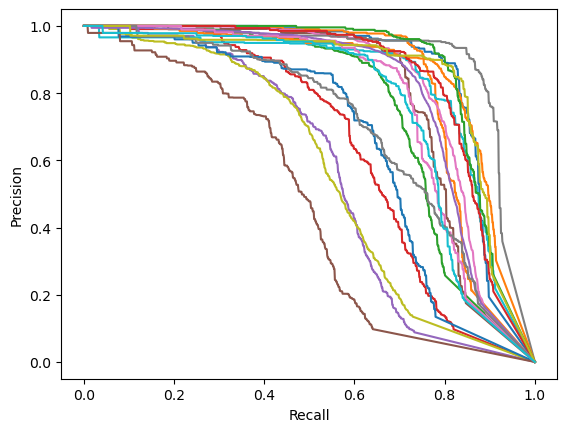

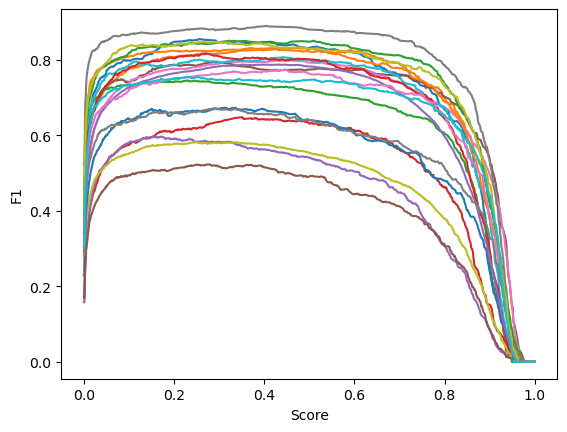

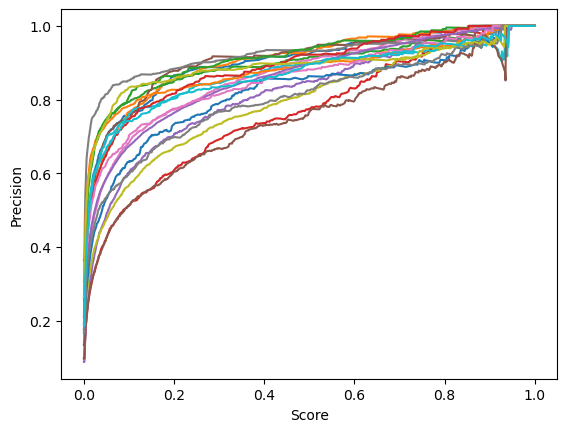

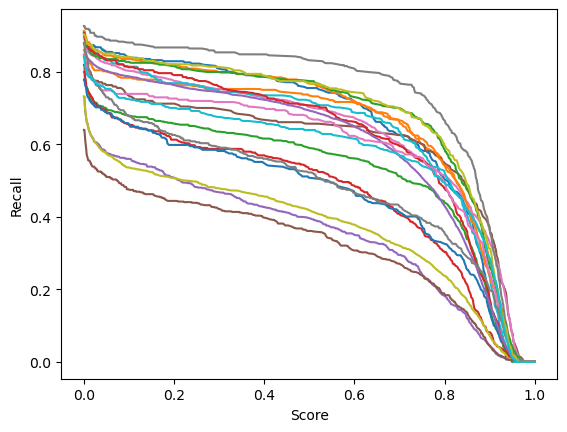

In [11]:
score_thresh = 0.001
iou_thresh = 0.5
# Compute mAP by custom fast but simple evaluator
metric = DetEvaluator()
results = eval()
print(f"mAP@50: {results['map_50']:.2%}")  # mAP@50: 75.60%, 23.9s
print(f"mean precision of all classes at max F1: {results['mp']:.2%}")  # 83.32%
print(f"mean recall of all classes at max F1: {results['mr']:.2%}")  # 68.17%

curves = results['curves']
for x_curve, y_curves, x_label, y_label in curves:
    for idx, y_curve in enumerate(y_curves):
        plt.plot(x_curve, y_curve, label=f"Idx {idx}")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.legend()
    plt.show()

### Results

| Runs                                             | mAP@50 | Duration |
|--------------------------------------------------|--------|----------|
| 2024xxxx-xxxxxx/ckpt_last.pt (overfit-no-aug)    | xx.xx% | xx.xs    |
| 2024xxxx-xxxxxx/ckpt_last.pt (no-multiscale 416) | xx.xx% | xx.xs    |
| 2024xxxx-xxxxxx/ckpt_last.pt (no-multiscale 608) | xx.xx% | xx.xs    |
| 2024xxxx-xxxxxx/ckpt_last.pt (multiscale 608)    | xx.xx% | xx.xs    |